In [130]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt

In [214]:
pwsize = "results/BFOLD_knn_f1_1691940950.pkl"
palpha = "results/BFOLD_knn_f1_1691934871.pkl"
# pwsize = open_pkl(pwsize)
# palpha = open_pkl(palpha)
# palpha[1] = palpha[-1]
# del palpha[-1]

In [140]:
for k in palpha.keys():
    palpha[k] = 100*np.array(palpha[k])

In [267]:
import matplotlib.pyplot as plt

def plot_variation_alpha(path):
    palpha = open_pkl(path)
    palpha[1] = palpha[-1]
    del palpha[-1]
    data = palpha

    fig, ax = plt.subplots(figsize=(8, 3.5))

    sorted_keys = sorted(data.keys())

    # Tri des valeurs associées aux clés
    sorted_values = [data[key] for key in sorted_keys]

    # Création du graphe boxplot avec échelle logarithmique sur l'axe x
    bplot2 = ax.boxplot(sorted_values, labels=1-np.array(sorted_keys),patch_artist=True, notch=True,showfliers=False)

    colors_ = (len(sorted_keys)-1)*['tab:blue'] + ['tab:orange']
    for _, line_list in bplot2.items():
        for line in line_list:
            line.set_color('black')
            line.set_linewidth(0.75)
    for patch, color in zip(bplot2['boxes'], colors_):
        patch.set_facecolor(color)
        patch.set_alpha(0.75)
    

    ax.legend([bplot2["boxes"][0], bplot2["boxes"][-1]], ['L-WECS', 'WECS'], loc='upper right')
    ax.set_xlabel('Local weights ($\\alpha$)')
    ax.set_ylabel('F1-score (x100)')
    # ax.set_title('Variation of F1-score with local weights ($\\alpha$)')
    ax.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    plt.show()



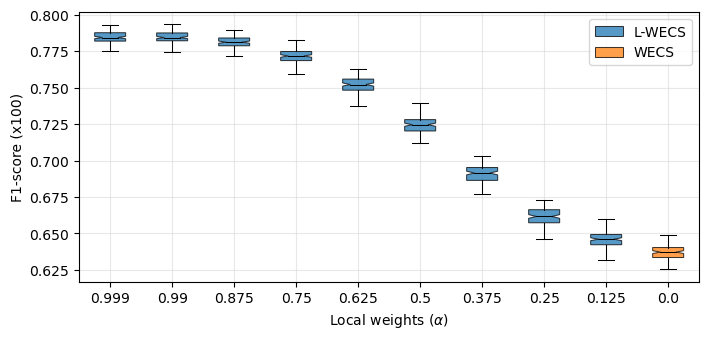

In [268]:
plot_variation_alpha(palpha)

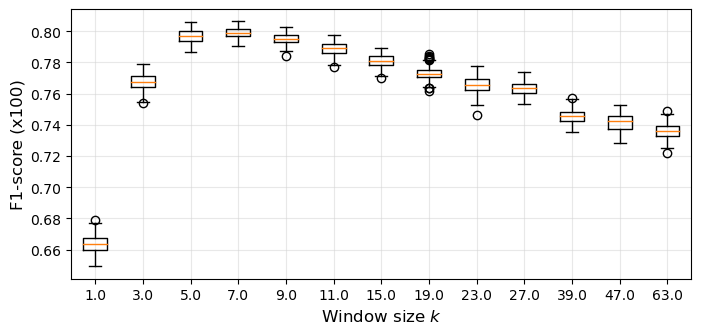

In [191]:
data = pwsize

fig, ax = plt.subplots(figsize=(8, 3.5))

sorted_keys = sorted(data.keys())

# Tri des valeurs associées aux clés
sorted_values = [data[key] for key in sorted_keys]

# Création du graphe boxplot avec échelle logarithmique sur l'axe x
bplot2 = ax.boxplot(sorted_values, labels=np.array(sorted_keys))#,patch_artist=True)

# colors_ = (len(sorted_keys)-1)*['lightgreen' ]
# for patch, color in zip(bplot2['boxes'], colors_):
#     patch.set_facecolor(color)
#     patch.set_alpha(0.5)

# ax.legend([bplot2["boxes"][0], bplot2["boxes"][-1]], ['L-WECS', 'WECS'], loc='upper right')
ax.set_xlabel('Window size $k$', fontsize=12)
ax.set_ylabel('F1-score (x100)', fontsize=12)
# ax.set_title('Variation of F1-score with local weights ($\\alpha$)')
ax.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
plt.show()


In [279]:
import pandas as pd
mf7 = "results/multi_f1__7_1691956910.pkl"
mfg = "results/multi_f1_-1_1691956910.pkl"
mf63 = "results/multi_f1_63_1691956910.pkl"

mf7,le = open_pkl(mf7)
mfg,le = open_pkl(mfg)
mf63,le = open_pkl(mf63)

In [294]:
pd.DataFrame(mf7.std(axis=0), index=le, columns=le).round(2)

,agricultural land,bare ground plain,forest,no change,urbanized area
agricultural land,1.26,0.53,0.95,0.78,1.02
bare ground plain,0.81,0.62,0.79,0.62,0.78
forest,0.35,0.37,1.65,1.17,1.47
no change,0.24,0.29,1.03,0.86,0.79
urbanized area,3.89,2.31,4.09,3.16,4.78


In [296]:
pd.DataFrame(mf63.mean(axis=0), index=le, columns=le).round(1)

\begin{tabular}{lrrrrr}
\toprule
 & agricultural land & bare ground plain & forest & no change & urbanized area \\
\midrule
agricultural land & 55.600000 & 2.000000 & 18.700000 & 8.400000 & 15.300000 \\
bare ground plain & 25.200000 & 29.900000 & 24.100000 & 7.500000 & 13.300000 \\
forest & 16.000000 & 3.900000 & 49.200000 & 13.100000 & 17.800000 \\
no change & 27.300000 & 6.600000 & 36.000000 & 12.300000 & 17.800000 \\
urbanized area & 21.100000 & 1.900000 & 28.400000 & 13.300000 & 35.300000 \\
\bottomrule
\end{tabular}



In [299]:
pd.DataFrame(mfg.mean(axis=0), index=le, columns=le).round(1)

,agricultural land,bare ground plain,forest,no change,urbanized area
agricultural land,41.2,11.5,8.6,7.7,31.0
bare ground plain,23.6,19.8,12.2,9.7,34.7
forest,16.4,11.2,19.2,12.8,40.3
no change,22.9,12.2,15.4,11.7,37.8
urbanized area,23.2,11.6,13.7,12.9,38.7


,agricultural land,bare ground plain,forest,no change,urbanized area
agricultural land,55.55,2.05,18.69,8.37,15.34
bare ground plain,25.24,29.88,24.14,7.47,13.26
forest,16.05,3.95,49.18,13.05,17.77
no change,27.26,6.64,35.98,12.31,17.81
urbanized area,21.05,1.88,28.43,13.34,35.29


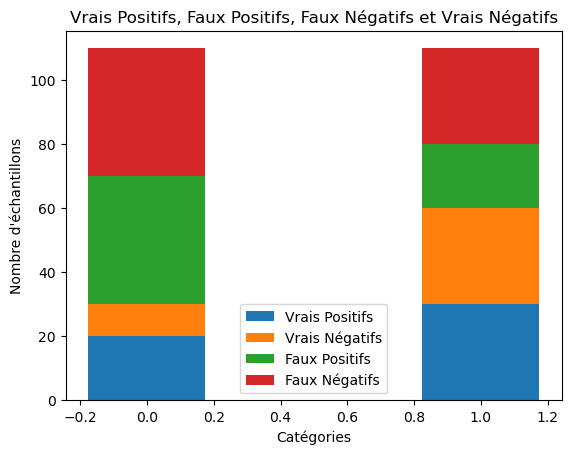

In [113]:
import matplotlib.pyplot as plt

# Exemple de valeurs prédites (ypred) et valeurs réelles (y) pour les deux exemples
ypred_1 = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
y_1 = [1, 1, 0, 0, 1, 0, 1, 0, 1, 0]

ypred_2 = [0, 1, 1, 0, 1, 0, 1, 1, 0, 0]
y_2 = [1, 1, 0, 0, 1, 0, 1, 0, 1, 0]

# Fonction pour calculer les valeurs TP, FP, FN, TN
def calculate_metrics(ypred, y):
    TP = sum(1 for p, t in zip(ypred, y) if p == 1 and t == 1)
    FP = sum(1 for p, t in zip(ypred, y) if p == 1 and t == 0)
    FN = sum(1 for p, t in zip(ypred, y) if p == 0 and t == 1)
    TN = sum(1 for p, t in zip(ypred, y) if p == 0 and t == 0)
    total_samples = len(ypred)
    TP_prop = TP / total_samples * 100
    FP_prop = FP / total_samples * 100
    FN_prop = FN / total_samples * 100
    TN_prop = TN / total_samples * 100


    return TP_prop, FP_prop, FN_prop, TN_prop

# Calcul des valeurs TP, FP, FN, TN pour chaque exemple
TP_1, FP_1, FN_1, TN_1 = calculate_metrics(ypred_1, y_1)
TP_2, FP_2, FN_2, TN_2 = calculate_metrics(ypred_2, y_2)

# Création des barplots empilés
categories = ['Vrais Positifs', 'Vrais Négatifs', 'Faux Positifs', 'Faux Négatifs']
values_1 = [TP_1, TN_1, FP_1, FN_1, ]
values_2 = [TP_2, TN_2, FP_2, FN_2, ]

bar_width = 0.35
index = 2

z=0
z2=0
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for n,i in enumerate(values_1):
    plt.bar(0, values_1, bar_width,bottom=z,color=colors[n],label=None)
    z=z+i
for n,i in enumerate(values_2):
    plt.bar(1, values_2, bar_width, bottom=z2,color=colors[n],label=categories[n])
    z2=z2+i

plt.xlabel('Catégories')
plt.ylabel('Nombre d\'échantillons')
plt.title('Vrais Positifs, Faux Positifs, Faux Négatifs et Vrais Négatifs')
# plt.xticks([i + bar_width / 2 for i in index], categories)
plt.legend()
plt.show()


In [11]:
import numpy as np
import os, sys

sys.path.append("../")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from utils import load_h5, random_shuffle
from tensorflow.keras.utils import to_categorical


def balance_dataset(X, Y, shuffle=False):
    """Balance the dataset by taking the minimum number of samples per class (under-sampling)

    Parameters
    ----------
    X : numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands)

    Y : numpy array
        dataset of labels in string, shape (n_samples,)

    shuffle : bool, optional
        Shuffle the dataset, by default False

    Returns
    -------
    numpy array
        balanced dataset of images in float32, shape (n_samples, height, width, n_bands)

    numpy array
        balanced dataset of labels in string, shape (n_samples,)
    """
    if shuffle:
        X, Y = random_shuffle(X, Y)
    cat, counts = np.unique(Y, return_counts=True)
    min_count = np.min(counts)
    X_bal = []
    Y_bal = []
    for category in cat:
        idx = np.where(Y == category)[0]
        idx = idx[:min_count]
        X_bal.append(X[idx])
        Y_bal.append(Y[idx])
    X_bal = np.concatenate(X_bal)
    Y_bal = np.concatenate(Y_bal)
    return X_bal, Y_bal


def prepare_data(
    path,
    band_max=[0, 1, 2],
    balanced=True,
    shuffle=True,
):
    """Prepare the data for the CNN model, it suppose that the data are stored in hdf5 files in the same folder and named "data_train.h5" and "data_test.h5"

    Parameters
    ----------
    ipath : str
        Path to the hdf5 files

    frac_val : float, optional
        Fraction of the dataset to use for validation, by default 0.15

    band_max : list, optional
        List of the bands to use, by default [0, 1, 6, 7]

    balanced : list, optional
        List of boolean to balance the dataset train and test, by default [False, False]

    shuffle : bool, optional
        Shuffle the dataset (seed=42), by default True

    categorical : bool, optional
        If True, encode the labels using to_categorical, by default False

    Returns
    -------
    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the train set

    numpy array
        dataset of labels in string, shape (n_samples,) of the train set

    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the test set

    numpy array
        dataset of labels in string, shape (n_samples,) of the test set

    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the validation set

    numpy array
        dataset of labels in string, shape (n_samples,) of the validation set

    sklearn.preprocessing.LabelEncoder
        LabelEncoder object to transform the labels into integers
    """
    X, Y = load_h5(path)
    if band_max is not None:
        X = X[:, :, :, band_max]

    if shuffle:
        X, Y = random_shuffle(X, Y)
    Y = np.where(Y != "no change", "change", Y)

    if balanced:
        X, Y = balance_dataset(X, Y)

    Le = LabelEncoder()
    y = Le.fit_transform(Y)

    X = X.reshape(X.shape[0], -1)
    return X, y, Le


def prepare_data_split(
    path,
    band_max=[0, 1, 2],
    balanced=[False, False],
    shuffle=True,
):
    """Prepare the data for the CNN model, it suppose that the data are stored in hdf5 files in the same folder and named "data_train.h5" and "data_test.h5"

    Parameters
    ----------
    ipath : str
        Path to the hdf5 files

    frac_val : float, optional
        Fraction of the dataset to use for validation, by default 0.15

    band_max : list, optional
        List of the bands to use, by default [0, 1, 6, 7]

    balanced : list, optional
        List of boolean to balance the dataset train and test, by default [False, False]

    shuffle : bool, optional
        Shuffle the dataset (seed=42), by default True

    categorical : bool, optional
        If True, encode the labels using to_categorical, by default False

    Returns
    -------
    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the train set

    numpy array
        dataset of labels in string, shape (n_samples,) of the train set

    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the test set

    numpy array
        dataset of labels in string, shape (n_samples,) of the test set

    numpy array
        dataset of images in float32, shape (n_samples, height, width, n_bands) of the validation set

    numpy array
        dataset of labels in string, shape (n_samples,) of the validation set

    sklearn.preprocessing.LabelEncoder
        LabelEncoder object to transform the labels into integers
    """
    X, Y = load_h5(path)

    if band_max is not None:
        X_train = X_train[:, :, :, band_max]
        X_test = X_test[:, :, :, band_max]

    if shuffle:
        X_train, Y_train = random_shuffle(X_train, Y_train)
        X_test, Y_test = random_shuffle(X_test, Y_test)

    Le = LabelEncoder()
    y_train = Le.fit_transform(Y_train)
    y_test = Le.transform(Y_test)

    if balanced[0]:
        X_train, y_train = balance_dataset(X_train, y_train)
    if balanced[1]:
        X_test, y_test = balance_dataset(X_test, y_test)

    return X_train, X_test, y_train, y_test, Le


In [10]:
import os, glob, sys
import numpy as np

sys.path.append("../")

from utils import *
from data.process.dataset_loader import prepare_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold


# path = "../../../results_II/aweig/*.h5"
type_an = "win_anII"  # "aweig"
path = f"../../results_II/{type_an}/*.h5"
times_name = str(time.time()).split(".")[0]
output_dir = f"../results/{type_an}_knn_II_{times_name}/"
os.makedirs(output_dir, exist_ok=True)
pathd = glob.glob(path)

pathd.sort()

knn_f1 = {}

inputh_data = pathd[0]
# weights = float(inputh_data.split("_")[2][1:])
weights = float(inputh_data.split("_")[4])


In [13]:
X, Y = load_h5(inputh_data)

In [14]:
np.unique(Y, return_counts=True)

(array(['agricultural land', 'bare ground plain', 'forest', 'no change',
        'urbanized area'], dtype='<U20'),
 array([  5810,  14572,   9351, 917871,    331]))

In [43]:
import numpy as np

def oversample_indices(indices, desired_size):
    """
    Oversamples the given indices to achieve the desired size.
    
    Parameters:
        indices (list or numpy array): Indices of the minority class samples.
        desired_size (int): Desired size after oversampling.
        
    Returns:
        oversampled_indices (numpy array): Array of oversampled indices.
    """
    num_indices = len(indices)
    oversample_factor = desired_size // num_indices
    
    # Duplicate the indices based on the oversample factor
    oversampled_indices = np.repeat(indices, oversample_factor)
    
    # Calculate the remaining number of samples needed to reach the desired size
    remaining_samples = desired_size - len(oversampled_indices)
    
    # Randomly sample the remaining indices to fill up to the desired size
    if remaining_samples > 0:
        remaining_indices = np.random.choice(indices, remaining_samples, replace=True)
        oversampled_indices = np.concatenate((oversampled_indices, remaining_indices))
    oversampled_indices = np.concatenate((oversampled_indices,indices))
    oversampled_indices = np.random.permutation(oversampled_indices)

    return oversampled_indices

def oversampling_minority(X,Y):
    unique, counts = np.unique(Y, return_counts=True)
    sort_counts = np.argsort(counts)
    diff_first_to_sec = counts[sort_counts[1]]-counts[sort_counts[0]]
    min_class = unique[sort_counts[0]]
    idx = np.where(Y == min_class)[0]
    idx_over = oversample_indices(idx, diff_first_to_sec)

    idx_maj = np.where(Y != min_class)[0]
    idx_bal = np.concatenate((idx_maj, idx_over))
    X_bal = X[idx_bal]
    Y_bal = Y[idx_bal]
    return X_bal, Y_bal



In [107]:
from sklearn.ensemble import RandomForestClassifier
xx = X_b.reshape(X_b.shape[0], -1)[850000:]#.mean(axis=1)
# xx-=xx.min()
# xx/=(xx.max()-xx.min())
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, criterion="entropy")

In [108]:
from sklearn.metrics import f1_score

In [109]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
yy = le.fit_transform(Y_b)
yy = yy[850000:]
rf.fit(xx, yy)
le.transform(le.classes_)


array([0, 1, 2, 3, 4])

In [112]:
yp = rf.predict(xx)
np.unique(yp, return_counts=True)

(array([0, 1, 2, 3, 4]), array([  815,   482,   935, 95372,  5810]))

In [198]:
from sklearn.metrics import confusion_matrix

In [208]:
(100*confusion_matrix(yp,yy,labels=le.transform(le.classes_),normalize='true')).round(1)

import pandas as pd

pd.DataFrame(100*confusion_matrix(yy,yp,labels=le.transform(le.classes_),normalize='true'),index=le.classes_,columns=le.classes_).round(1)

,agricultural land,bare ground plain,forest,no change,urbanized area
agricultural land,94.1,0.0,0.0,5.9,0.0
bare ground plain,0.0,94.1,0.0,5.9,0.0
forest,0.0,0.0,95.2,4.8,0.0
no change,0.0,0.0,0.0,100.0,0.0
urbanized area,0.0,0.0,0.0,0.0,100.0


In [197]:
f1_score(yy,yp,average=None,labels=le.transform(le.classes_))

array([0.96966092, 0.96981891, 0.97548252, 0.99932849, 1.        ])

In [193]:
from sklearn.metrics import accuracy_score

accuracy_score(yp,yy,

0.9987622565610073

In [192]:
f1  =f1_score(yp, yy, average=None, labels= le.transform(le.classes_))
f1_score(yp, yy, average="weighted")

0.9987792711542841

In [128]:
    f1scmul = {}
    for i in le.classes_:
        f1scmul[i] = []
    f1scmul

{'agricultural land': [],
 'bare ground plain': [],
 'forest': [],
 'no change': [],
 'urbanized area': []}

In [125]:
np.unique(Y_b[850000:],return_counts=True)

(array(['agricultural land', 'bare ground plain', 'forest', 'no change',
        'urbanized area'], dtype='<U20'),
 array([  866,   512,   982, 95244,  5810]))

In [129]:

for i in le.transform(le.classes_):
    print(i, le.inverse_transform([i])[0],f" f1: {f1[i]}")

0 agricultural land  f1: 0.9696609161213563
1 bare ground plain  f1: 0.9698189134808853
2 forest  f1: 0.9754825247782994
3 no change  f1: 0.9993284928862216
4 urbanized area  f1: 1.0


In [50]:
X_b, Y_b = oversampling_minority(X, Y)
np.unique(Y_b, return_counts=True)

(array(['agricultural land', 'bare ground plain', 'forest', 'no change',
        'urbanized area'], dtype='<U20'),
 array([  5810,  14572,   9351, 917871,   5810]))

In [48]:
y2  = Y[np.where(Y != min_class)[0]]
y2 = np.concatenate([y2, Y[idx_over]])
np.unique(y2, return_counts=True)

(array(['agricultural land', 'bare ground plain', 'forest', 'no change',
        'urbanized area'], dtype='<U20'),
 array([  5810,  14572,   9351, 917871,   5810]))